# Automated SEC Keyword Scraping Tool

This notebook automatically searched through the SEC filings of companies and returns the number of times a keyword appears in each of the companies filings. It also looks into whether that keyword is used in a table and returns a data frame of the how the word is used and how many times each keyword appears in a table. Currently it is set up to search for the adoption of Cryptocurrency related keywords.

## Import Packages

In [1]:
import edgar
import pandas as pd
import numpy as np
import time
import os
from bs4 import BeautifulSoup
import bs4 as bs
import codecs
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import random
import urllib.request
from collections import OrderedDict
import json
import re
from datetime import datetime
from datetime import date
from urllib.request import urlopen
import yfinance as yf
import matplotlib.pyplot as plt
start_time = datetime.now()

In [2]:
headers_list = [
    # Firefox 77 Mac
    {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "https://www.google.com/",
    "DNT": "1",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1"
    },
    # Firefox 77 Windows
    {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.google.com/",
    "DNT": "1",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1"
    },
    # Chrome 83 Mac
    {
    "Connection": "keep-alive",
    "DNT": "1",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Dest": "document",
    "Referer": "https://www.google.com/",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8"
    },
    # Chrome 83 Windows 
    {
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-User": "?1",
    "Sec-Fetch-Dest": "document",
    "Referer": "https://www.google.com/",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9"
    }
]

## This will import every CIK number for public companies

In [3]:
cik_url="https://www.sec.gov/files/company_tickers.json"
response = urlopen(cik_url)
data_json = json.loads(response.read())
data_cik=pd.DataFrame(data_json).T
data_cik.drop(['title'], axis = 1, inplace = True)
data_cik = data_cik.groupby(['cik_str']).head(1)
data_cik

,cik_str,ticker
0,320193,AAPL
1,789019,MSFT
2,1652044,GOOGL
3,1018724,AMZN
4,1318605,TSLA
...,...,...
12022,1764791,ORPHY
12101,1793497,UVIX
12103,1795168,OGGCS
12127,1501729,FSEN


In [4]:
CIK = data_cik['cik_str']
tickers = data_cik['ticker']

For illustration purposes I have selected a few CIK Numbers below as running it for every company takes a while. In order to run it for every company comment out the cell below with a #.

In [5]:
CIK = ['896493','1507605','1403161' '19617', '1318605', '0001457512', '0001702014', '0001709702', '0001050446','0001167419' ]
CIK =['0001167419']

## Extract URLs

In [329]:
filling_type = '10-K' #8-K 10-Q
num_of_fillings = 2 #Number of filings for each company
within_year = 2 #Number of years to go back
recent_year = date.today().year

name_lst = []
cik_lst = []
ticker_lst = []
sic_lst = []
industry_type_lst = []
state_location_lst = []
state_inc_lst = []
filling_date_lst = []
url_lst = []



for item,ticker in zip(CIK, tickers):
    link = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + str(item) + '&type=' + filling_type + '&dateb=&count=100&scd=filings'
    print(link) #Use for debug, if you find the bug, click the url and check why is the bug
    headers = random.choice(headers_list)
    r = requests.Session()
    r.headers = headers
    retry = Retry(connect=5, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    r.mount('http://', adapter)
    r.mount('https://', adapter)
    #time.sleep(np.random.uniform(1,2))
    try:
        html = r.get(link).text
    except TimeoutError:
        continue
    soup = BeautifulSoup(html, "html.parser")
    
    if soup.find("div", class_="companyInfo") != None: #If we can find company info table
        if soup.find('span', class_ = 'companyName') != None: #If we can find company name and CIK
            company_info = str(soup.find("span", class_ = 'companyName'))
            start = company_info.find('>')
            end = company_info.find('<acronym')
            company_name = company_info[start+1:end].replace('amp;', '').replace('  ', ' ')
            company_cik = re.findall(r"CIK=(\d+)", company_info)[0]
            
            if soup.find('p', class_ = 'identInfo') != None: #If we can find company identification info
                company_ident = soup.find('p', class_ = 'identInfo')
                if company_ident.find('acronym', title="Standard Industrial Code") != None: #if we can find SIC code
                    company_ident = str(company_ident)
                    company_sic = re.findall(r"SIC=(\d+)", company_ident)[0]
                    if re.findall(r"- ([&;\w\sA-Za-z]+)", company_ident) != []: #if we can find company industry
                        company_industry = re.findall(r"- ([&;\w\sA-Za-z]+)", company_ident)[0].replace('amp;', '')
                        if (company_ident.find('State=') != -1) & (company_ident.find('State of Inc.') != -1): # if we can find state location and state of Inc.
                            company_state_location = re.findall(r"State=([a-zA-Z0-9]+)", company_ident)[0]
                            company_state_inc = re.findall(r"<strong>([a-zA-Z0-9]+)</strong>", company_ident)[0]
                            if soup.find('table', class_ = 'tableFile2') != None: #if we can find filling table
                                table = soup.find('table', class_ = 'tableFile2')
                                fillings = table.find_all('tr')[1:] #find all documents
                            
                                for filling in fillings: #search each filling
                                    document_info = filling.find_all('td')
                                    if (document_info[0].string == filling_type) and (int(document_info[3].string[:4]) > (recent_year - within_year)): #if we the document is 10-K and the year of filling within range and dont reach search limit
                                        filling_date = document_info[3].string
                                        url = "https://www.sec.gov" + str(document_info[1].find('a', id = 'documentsbutton', href = True))[9:-37]
                                        html = r.get(url).text
                                        html = html[html.find('td scope="row">1<'):]
                                        html = html[html.find('/Archives/edgar/data/'):]
                                        filling_url = "https://www.sec.gov" + html[0:html.find('>') - 1] #Find the 10-K url
                                        name_lst.append(company_name)
                                        cik_lst.append(company_cik)
                                        ticker_lst.append(ticker)
                                        sic_lst.append(company_sic)
                                        industry_type_lst.append(company_industry)
                                        state_location_lst.append(company_state_location)
                                        state_inc_lst.append(company_state_inc)
                                        filling_date_lst.append(filling_date)
                                        url_lst.append(filling_url)
                                    
                                    else:
                                        continue
                            else:#if we cannot find filling table
                                continue
                        else: #if we cannot find company state and state of inc
                            continue
                    else: # if we cannot find company industry
                        continue
                else: #if we cannot find SIC code
                    continue
            else: #If we cannot find company identification info
                continue
        else: #If we cannot find the company name and CIK
            continue
    else: #If we cannot find company info
        continue    

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=320193&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=789019&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1652044&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1018724&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1318605&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1067983&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1326801&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1046179&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=731766&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1163165&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1089113&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=316709&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1067839&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1156039&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=936468&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1000184&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=887028&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=217410&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=36104&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1065521&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=872589&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=10795&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=713676&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=875320&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1463157&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1133421&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=823768&type=10-K&dateb=&count=100&scd=filings
https://www.sec.go

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1032208&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=797468&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=7084&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1045520&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1002242&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=882835&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=4904&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1751788&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1099590&type=10-K&dateb=&count=100&scd=filings
https://www.sec.go

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1093557&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=766704&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=72903&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1090012&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=726728&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1418091&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1063761&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1048515&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1534701&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=844150&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=906107&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=849395&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=875045&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1477333&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=79879&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1498632&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1671933&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1012037&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=35527&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1289490&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=936340&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=936958&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1136869&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1057352&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1450346&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=33185&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1381197&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=103379&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1447629&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=912593&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=732834&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1175454&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1323404&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=815097&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1601712&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1094285&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=947484&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=21076&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1511737&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1805284&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1786352&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=79282&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=97210&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1634997&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=889132&type=10-K&dateb=&count=100&scd=filings
https://www.sec.go

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=842023&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=91419&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=932872&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1463172&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=352541&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1288784&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=813762&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1041668&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1646972&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1100682&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1172724&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=6201&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=46080&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1766502&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1093691&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=36966&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1692819&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1161611&type=10-K&dateb=&count=100&scd=filings
https://www.sec.g

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1468174&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1591698&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1298675&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=769218&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1267238&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=105016&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1126975&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1438569&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1015820&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1283630&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1671750&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1557860&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1135951&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1583708&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=109380&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=908255&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1177609&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1013871&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1308547&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1046311&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1069202&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=929058&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=315852&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=350894&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=70318&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1274494&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=20212&type=10-K&dateb=&count=100&scd=filings
https://www.sec.g

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1465128&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=108312&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1436786&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=355811&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1653482&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=802481&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1357615&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1437578&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=785161&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1656081&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1791863&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=921738&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=798941&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=16058&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=52827&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1642896&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1166003&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1647639&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1477049&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1601994&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=78239&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1826470&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1370418&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1102934&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1801075&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=84748&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=868671&type=10-K&dateb=&count=100&scd=filings
https://www.sec

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=39911&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1361113&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1359841&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=70866&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1003078&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1142750&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1040971&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=866291&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=861878&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=921082&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1533475&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=30625&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1084048&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=730263&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=876437&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1144980&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1492422&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1849853&type=10-K&dateb=&count=100&scd=filings
https://www.sec

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1334036&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1411207&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1341766&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=816956&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1837430&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=840489&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1437774&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1273813&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1455633&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=856982&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1124198&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1534504&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1039828&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1569345&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1552275&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1530256&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1551306&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1567683&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1345105&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1848763&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1809122&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1580560&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=857855&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1828365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840776&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=803649&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819848&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1028918&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1417398&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1361371&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1699136&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=850209&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1090116&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1410384&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=860748&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=43920&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1379438&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1648257&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=797721&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=99780&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1653653&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=103730&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1754195&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=67887&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1627475&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840572&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1406666&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1841804&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1476765&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1275617&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1845257&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=819793&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1124804&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1374535&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1759655&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1121142&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1655210&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1511337&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=912615&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=940942&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=894081&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1800347&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1690511&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1307748&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1444380&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=55242&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1792045&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1375365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=105418&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1756607&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1726978&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=886346&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1446847&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1546417&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1818093&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1445168&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=59440&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1340736&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1018840&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1849635&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1276671&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1706509&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1834488&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1487739&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1793862&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1764443&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1577526&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1576940&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1578732&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1395942&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=715072&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1503584&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1190935&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1465740&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=850141&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1413159&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1375877&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=703351&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1484612&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1473579&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=811596&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1402328&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1508478&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1657573&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=790359&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1022408&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1856608&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1409970&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=896841&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1743759&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1770121&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=744218&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=102037&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1572957&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1039065&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1434614&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1841968&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=811589&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1734713&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1094366&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1127703&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1030469&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1836833&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1262976&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=798359&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1050825&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=49754&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1806952&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1517228&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=877422&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1835059&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1260563&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1712463&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1829432&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=907254&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=310354&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1512920&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1750153&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1332349&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1810739&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1740594&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1837412&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1700849&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=26058&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1842912&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1023313&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1691445&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=897448&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1534675&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=855654&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1354327&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1029142&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1434621&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1080259&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1734342&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1068875&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1492165&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1268884&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1072379&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1716583&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=946647&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1582568&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=827187&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=805267&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1091223&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1802457&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1271214&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1609804&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=810136&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1789769&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1743725&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=921299&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1278895&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1008654&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1773751&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1401708&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=876779&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1798100&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1693256&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1851112&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1828183&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=69488&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=790500&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1818644&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1000623&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1370755&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1655891&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1538849&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=46250&type=10-K&dateb=&count=100&scd=filings
https://www.sec

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1834489&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1851194&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1823878&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1818382&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1069899&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1759425&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1643303&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1744781&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=761238&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1288403&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1304421&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1866175&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1629019&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1828250&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1053352&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=947559&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=701347&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1267902&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1792781&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=357173&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1830210&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819133&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1195738&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1730430&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1300391&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1484778&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=69633&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1110611&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1816431&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=890447&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1713748&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1739614&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1683541&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1769484&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1722438&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=896156&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1816581&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1838219&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1841389&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1830487&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1287098&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1447362&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1625414&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1587987&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1044777&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1728117&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1818787&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1437958&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=834365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1845337&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1827076&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1087786&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1554697&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=799850&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=775215&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1841761&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=807863&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1219120&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1777319&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1861560&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=835948&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1868941&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1383414&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1412665&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=88948&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1708259&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1826000&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1169445&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1593034&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1854964&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=844965&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1766400&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1620737&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1538263&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=862831&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1772921&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1795251&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1612630&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=903419&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1308927&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1816261&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1836274&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1857190&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1834755&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1839127&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1829615&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1834628&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1724755&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840463&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840148&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1812923&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1825473&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1468327&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1143513&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=891290&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=14846&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1129155&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1839132&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1268533&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1830197&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1562463&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1829042&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1083301&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1838163&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819790&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1189740&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1870600&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1289213&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1831006&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1836894&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1530979&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1368514&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1733294&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1846017&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1715768&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1288992&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1697500&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1370450&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1865187&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1847874&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1327318&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=928658&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1657045&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1835856&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1818880&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1821606&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1006840&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1842430&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1646188&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1853021&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1915328&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=789933&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1879248&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1531177&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1041657&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1850270&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=706698&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1850902&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1860782&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1809353&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1870997&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1729173&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840792&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1375340&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=8063&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1284940&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1791725&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=851170&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1596961&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=805928&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=809173&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1497186&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1503707&type=10-K&dateb=&count=100&scd=filings
https://www.sec.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1729997&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=850033&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1640266&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1382101&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1261249&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=874396&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1166663&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1515940&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1643953&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1838666&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=829365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1593548&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1267813&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1567529&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1721741&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1719489&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1833769&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=916793&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1884516&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1746129&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1614806&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1386067&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1061353&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1355848&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1786248&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1866782&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1826671&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1803901&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1040470&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1101396&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1602658&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1767837&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1391437&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1084577&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1370416&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1814114&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=859796&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1181504&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1462586&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1245648&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1833764&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1392091&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=714256&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=803164&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1847590&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=943033&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1808997&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=766011&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1869824&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1341235&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=877019&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1377630&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1610682&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1280776&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1504234&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1364128&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1503290&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1595527&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1684693&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1305168&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1857086&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1337013&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819157&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1824036&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1662991&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1058811&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1302028&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=352825&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1828735&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1648087&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1332943&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1834342&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1867757&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1613780&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1874252&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1861622&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=894671&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=830487&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1738021&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=748790&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=31107&type=10-K&dateb=&count=100&scd=filings
https://www.sec

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1757840&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1072627&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1821318&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1303942&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1584547&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1810140&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1828522&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1199004&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1836875&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1823144&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1253176&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=890119&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=315131&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1339970&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1788028&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1770141&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1368148&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1661059&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1742770&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1833214&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1488917&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1367920&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1850079&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1516899&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1332551&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1702924&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1855751&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=731653&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1809158&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=740806&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1141197&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1459188&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1336835&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1018735&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1744494&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1410428&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=866643&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1095348&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1693011&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1833141&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1056285&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1510593&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1724009&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1408201&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1580149&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1718405&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1113513&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1276469&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1718939&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1337068&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1615055&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=798528&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1043186&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1496690&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1095146&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1274792&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1120970&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1057083&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=931584&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1799011&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1769697&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=716314&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=914712&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=810943&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1430306&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1008586&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1224133&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1630113&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1690080&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=717806&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1275101&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1539778&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1763950&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=740664&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1363958&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1498232&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1080340&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1102432&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1512927&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=803578&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1607962&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1492674&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1401040&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=716643&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1181749&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1098146&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1455365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1626971&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=819913&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1362705&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1674440&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1409269&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1498148&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1437491&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=946936&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=946454&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1453593&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1213037&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1398733&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1612940&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1386301&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1691221&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1738827&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1643715&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1321851&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1077640&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1652539&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1430300&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1472012&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1659617&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1507957&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=933738&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=728387&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=917225&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1433309&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1406944&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1740279&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1784567&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1181505&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1098880&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=883975&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1739174&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1595353&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1731727&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=865058&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=101538&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1326205&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1668438&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1425355&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1735948&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1398006&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819704&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1817153&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1730773&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=863900&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=725394&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=66418&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1436229&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1821323&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1778651&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1297937&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1563298&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=722313&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1418149&type=10-K&dateb=&count=100&scd=filings
https://www.se

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1671818&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1101026&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1589150&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1299865&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=766792&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1540159&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1491829&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1064722&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1560258&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1730869&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1846715&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1681348&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=89140&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1616741&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1650696&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1570843&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1839285&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1580110&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1104038&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1611831&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1463833&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1502292&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1263011&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1300734&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1741534&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1406434&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1449349&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1161814&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1781397&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=727346&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1625901&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1074543&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1536394&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1636051&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=880984&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1288855&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=319016&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1617669&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1817004&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1705843&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1769725&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=98338&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1566243&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=351789&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=922612&type=10-K&dateb=&count=100&scd=filings
https://www.sec

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1593001&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1574094&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1787740&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=55234&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1700844&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1017655&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1021917&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1128189&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=100716&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1396536&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1276531&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1652842&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1319150&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1358403&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1766140&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1084370&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1536089&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=700764&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1657214&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1086303&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1362516&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1871928&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1652350&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1072772&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1052054&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1358656&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1681682&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1729427&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1474558&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1162896&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1125699&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=879682&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1451797&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1099369&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1676163&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1388180&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1160191&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1448324&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1021435&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1309057&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1435064&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1789383&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1555214&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=822746&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1356093&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1442492&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=832489&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1304409&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1561880&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1584693&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1346917&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1586554&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1549631&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1360442&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=945828&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1626556&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1094032&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1104280&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1355790&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=867028&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1591165&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1708410&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=847942&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1422296&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=725929&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1008653&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1659183&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1128353&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1627611&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1714379&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1132509&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1716621&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1616788&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1494413&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1089815&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1381871&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1465311&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1689490&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1030916&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1681556&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1140586&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1389518&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1407878&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1286459&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1750777&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1760026&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1803977&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1422768&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1813603&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=890725&type=10-K&dateb=&count=100&scd=filings
https://www

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1399306&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1353487&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1486452&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=944696&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1421204&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1492091&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1124197&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1403674&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=772263&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=726293&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1040850&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1672326&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1490873&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1660839&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1477472&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=883943&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=884380&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1575345&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1874315&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1875558&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1878057&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1879270&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1881551&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1869901&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1870144&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1871130&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1873504&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1848731&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1843983&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1842431&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1842966&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1884697&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1868269&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1903145&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1879848&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1871810&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1558924&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1879221&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1871717&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1871737&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1876581&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1877333&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1880661&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1892492&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1894630&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1723788&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1729637&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1735556&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1737995&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1741220&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1586009&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1618181&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1671077&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1661166&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840102&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1840856&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1820566&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1821534&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1829322&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1830569&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1836242&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1729678&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1690639&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1855351&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1855450&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1810560&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1825452&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1849166&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1844035&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1845136&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1845855&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1841125&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1784058&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1817241&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1610718&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1589149&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1563756&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1567925&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1698508&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1862681&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1859807&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1898416&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1898601&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1086313&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1669368&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1550453&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1560293&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1570132&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1575051&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1577134&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1575311&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1555039&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1489300&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1494582&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1786205&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1748669&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1819395&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1696025&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1696411&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=844551&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1793081&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1753373&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1835615&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1676197&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1679628&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1688554&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1699709&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=22701&type=10-K&dateb=&count=100&scd=filings
https://www.s

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1668069&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1658645&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1613685&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1627041&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1643319&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1645873&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1648365&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1649904&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1623414&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1879103&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1856071&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1856948&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1854149&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1852495&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1857518&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1860299&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1861853&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1849737&type=10-K&dateb=&count=100&scd=filings
https://ww

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1699018&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1617765&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1351051&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1700175&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=733337&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=783005&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1667944&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1027662&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1708715&type=10-K&dateb=&count=100&scd=filings
https://www.

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1400732&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1043156&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1575975&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1065598&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1471302&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1689066&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1562733&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1058828&type=10-K&dateb=&count=100&scd=filings
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1498291&type=10-K&dateb=&count=100&scd=filings
https://ww

In [330]:
company_df = pd.DataFrame({'CIK':cik_lst, 'Ticker':ticker_lst, 'Company Name':name_lst, 'SIC':sic_lst, 
                           'Industry':industry_type_lst, 'State Location':state_location_lst, 
                           'State Inc':state_inc_lst, 'Filling Date':filling_date_lst,
                          'URL':url_lst})

company_df = company_df.groupby('CIK').head(num_of_fillings) #Choose the top n (hyperparameter can be set by client) fillings
company_df

,CIK,Ticker,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL
0,0000320193,AAPL,Apple Inc.,3571,ELECTRONIC COMPUTERS,CA,CA,2021-10-29,https://www.sec.gov/Archives/edgar/data/320193...
1,0000789019,MSFT,MICROSOFT CORP,7372,SERVICES,WA,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...
2,0001652044,GOOGL,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...
3,0001652044,GOOGL,Alphabet Inc.,7370,SERVICES,CA,DE,2021-02-03,https://www.sec.gov/Archives/edgar/data/165204...
4,0001018724,AMZN,AMAZON COM INC,5961,RETAIL,WA,DE,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...
...,...,...,...,...,...,...,...,...,...
6426,0001493566,OTIC,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2022-02-28,https://www.sec.gov/Archives/edgar/data/149356...
6427,0001493566,OTIC,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2021-02-11,https://www.sec.gov/Archives/edgar/data/149356...
6428,0001844507,AVHI,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...
6429,0001371782,MVO,MV Oil Trust,1311,CRUDE PETROLEUM & NATURAL GAS,TX,DE,2022-03-17,https://www.sec.gov/Archives/edgar/data/137178...


## Input Keywords to Search For

In [5]:
keywords = ['digital asset',
            'cryptocurrency', 
            'cryptocurrencies', 
            'digital holdings',
            'bitcoin',
            'ethereum']

In [332]:
keywords_table_list=[]
for key in keywords:
    keywords_table = key + '_table'
    keywords_table_list.append(keywords_table)

In [333]:
columns = ['URL'] + keywords + keywords_table_list

## Search Through URLs for Keywords

In [334]:

data = pd.DataFrame(columns = columns)
whole_phrase ={}

for url in company_df['URL']:
    print('RUN TIME: ',datetime.now() - start_time)
    headers = random.choice(headers_list)
    #time.sleep(np.random.uniform(1,2))
    try:
        html = requests.get(url, headers=headers, timeout=(10,200)).text.lower() #, verify=False
        
    except:
        continue
        print('Timeout has been raised.')
        
    keyword_lst=[]
    keyword_table_lst=[]
    list_phrases=[]
    for key in keywords:
        keyword_lst.append(html.count(key))
        
        
        keyword_pos_lst = [pos.start() for pos in re.finditer(key, html)]
        keyword_cnt_table = 0
        for keyword_pos in keyword_pos_lst:
            if '</td>' in html[keyword_pos:keyword_pos + 50]:
                keyword_cnt_table += 1
                section = html[keyword_pos-50:keyword_pos + 50]
                start = '>'
                end = '<'
                phrase = (section.split(start))[1].split(end)[0]
                if phrase:
                    list_phrases.append(phrase)
                
                
            else:
                continue
        keyword_table_lst.append(keyword_cnt_table)
    keywords_all=[]    
    keywords_all = [url] + keyword_lst + keyword_table_lst                          
        
    df_length = len(data)
    data.loc[df_length] = keywords_all
    
    if len(list_phrases)>0:
        whole_phrase[url]=list_phrases
    


RUN TIME:  4:50:09.303223
RUN TIME:  4:50:09.582948
RUN TIME:  4:50:09.792018
RUN TIME:  4:50:09.943018
RUN TIME:  4:50:10.092380
RUN TIME:  4:50:10.307528
RUN TIME:  4:50:10.438538
RUN TIME:  4:50:10.723160
RUN TIME:  4:50:11.028493
RUN TIME:  4:50:11.357798
RUN TIME:  4:50:11.714398
RUN TIME:  4:50:11.933463
RUN TIME:  4:50:12.129448
RUN TIME:  4:50:12.310537
RUN TIME:  4:50:12.502579
RUN TIME:  4:50:12.777829
RUN TIME:  4:50:13.024827
RUN TIME:  4:50:13.159899
RUN TIME:  4:50:13.459484
RUN TIME:  4:50:13.657417
RUN TIME:  4:50:13.860456
RUN TIME:  4:50:14.035452
RUN TIME:  4:50:14.277432
RUN TIME:  4:50:14.645433
RUN TIME:  4:50:15.227929
RUN TIME:  4:50:15.898881
RUN TIME:  4:50:16.698794
RUN TIME:  4:50:16.946298
RUN TIME:  4:50:17.140543
RUN TIME:  4:50:17.320556
RUN TIME:  4:50:17.597654
RUN TIME:  4:50:17.896869
RUN TIME:  4:50:18.528967
RUN TIME:  4:50:19.083316
RUN TIME:  4:50:19.310857
RUN TIME:  4:50:19.532887
RUN TIME:  4:50:19.788896
RUN TIME:  4:50:20.055822
RUN TIME:  4

RUN TIME:  4:51:34.336615
RUN TIME:  4:51:34.492792
RUN TIME:  4:51:34.668736
RUN TIME:  4:51:34.865736
RUN TIME:  4:51:35.110924
RUN TIME:  4:51:35.382184
RUN TIME:  4:51:35.617748
RUN TIME:  4:51:35.819521
RUN TIME:  4:51:35.994114
RUN TIME:  4:51:36.169251
RUN TIME:  4:51:36.376408
RUN TIME:  4:51:36.538668
RUN TIME:  4:51:36.733665
RUN TIME:  4:51:36.933665
RUN TIME:  4:51:37.154226
RUN TIME:  4:51:37.396437
RUN TIME:  4:51:37.606437
RUN TIME:  4:51:37.794474
RUN TIME:  4:51:37.977474
RUN TIME:  4:51:38.178271
RUN TIME:  4:51:38.391270
RUN TIME:  4:51:38.693279
RUN TIME:  4:51:38.988305
RUN TIME:  4:51:39.215519
RUN TIME:  4:51:39.519976
RUN TIME:  4:51:39.685975
RUN TIME:  4:51:39.831979
RUN TIME:  4:51:40.048977
RUN TIME:  4:51:40.288976
RUN TIME:  4:51:40.541976
RUN TIME:  4:51:40.735987
RUN TIME:  4:51:40.901976
RUN TIME:  4:51:41.073098
RUN TIME:  4:51:41.202095
RUN TIME:  4:51:41.486743
RUN TIME:  4:51:41.693743
RUN TIME:  4:51:42.177746
RUN TIME:  4:51:42.695032
RUN TIME:  4

RUN TIME:  4:53:55.432791
RUN TIME:  4:53:55.962020
RUN TIME:  4:53:56.359140
RUN TIME:  4:53:56.573138
RUN TIME:  4:53:56.800146
RUN TIME:  4:53:56.994139
RUN TIME:  4:53:57.193142
RUN TIME:  4:53:57.613758
RUN TIME:  4:53:57.956759
RUN TIME:  4:53:58.232758
RUN TIME:  4:53:58.541760
RUN TIME:  4:53:58.722758
RUN TIME:  4:53:58.936761
RUN TIME:  4:53:59.112759
RUN TIME:  4:53:59.391760
RUN TIME:  4:53:59.551758
RUN TIME:  4:53:59.711369
RUN TIME:  4:53:59.886371
RUN TIME:  4:54:00.111367
RUN TIME:  4:54:00.317367
RUN TIME:  4:54:00.502368
RUN TIME:  4:54:00.697377
RUN TIME:  4:54:00.933373
RUN TIME:  4:54:01.123367
RUN TIME:  4:54:01.315671
RUN TIME:  4:54:01.424671
RUN TIME:  4:54:01.541670
RUN TIME:  4:54:01.846670
RUN TIME:  4:54:02.007670
RUN TIME:  4:54:02.176670
RUN TIME:  4:54:02.366672
RUN TIME:  4:54:02.576670
RUN TIME:  4:54:03.151670
RUN TIME:  4:54:03.769783
RUN TIME:  4:54:04.291987
RUN TIME:  4:54:04.742985
RUN TIME:  4:54:04.911985
RUN TIME:  4:54:05.080984
RUN TIME:  4

RUN TIME:  4:55:03.485271
RUN TIME:  4:55:03.708273
RUN TIME:  4:55:03.946346
RUN TIME:  4:55:04.177346
RUN TIME:  4:55:04.389249
RUN TIME:  4:55:04.629252
RUN TIME:  4:55:04.806253
RUN TIME:  4:55:04.964654
RUN TIME:  4:55:05.222726
RUN TIME:  4:55:05.408725
RUN TIME:  4:55:05.624725
RUN TIME:  4:55:05.851725
RUN TIME:  4:55:06.097536
RUN TIME:  4:55:06.343148
RUN TIME:  4:55:06.560149
RUN TIME:  4:55:06.739147
RUN TIME:  4:55:06.899148
RUN TIME:  4:55:07.054147
RUN TIME:  4:55:07.203150
RUN TIME:  4:55:07.406168
RUN TIME:  4:55:07.731147
RUN TIME:  4:55:08.094417
RUN TIME:  4:55:08.456416
RUN TIME:  4:55:08.877418
RUN TIME:  4:55:09.067419
RUN TIME:  4:55:09.326419
RUN TIME:  4:55:09.483419
RUN TIME:  4:55:09.614416
RUN TIME:  4:55:09.773416
RUN TIME:  4:55:09.958574
RUN TIME:  4:55:10.144574
RUN TIME:  4:55:10.380591
RUN TIME:  4:55:10.594575
RUN TIME:  4:55:10.832573
RUN TIME:  4:55:11.027573
RUN TIME:  4:55:11.264178
RUN TIME:  4:55:11.538179
RUN TIME:  4:55:11.687180
RUN TIME:  4

RUN TIME:  4:56:07.956725
RUN TIME:  4:56:08.101726
RUN TIME:  4:56:08.417881
RUN TIME:  4:56:08.719880
RUN TIME:  4:56:08.941879
RUN TIME:  4:56:09.108879
RUN TIME:  4:56:09.341878
RUN TIME:  4:56:09.557878
RUN TIME:  4:56:09.708878
RUN TIME:  4:56:09.858878
RUN TIME:  4:56:10.016880
RUN TIME:  4:56:10.185950
RUN TIME:  4:56:10.430948
RUN TIME:  4:56:10.653952
RUN TIME:  4:56:10.841948
RUN TIME:  4:56:11.188949
RUN TIME:  4:56:11.427144
RUN TIME:  4:56:11.566142
RUN TIME:  4:56:11.709143
RUN TIME:  4:56:11.879144
RUN TIME:  4:56:12.036143
RUN TIME:  4:56:12.182872
RUN TIME:  4:56:12.401875
RUN TIME:  4:56:12.592871
RUN TIME:  4:56:12.929871
RUN TIME:  4:56:13.244872
RUN TIME:  4:56:13.459872
RUN TIME:  4:56:13.745873
RUN TIME:  4:56:14.040872
RUN TIME:  4:56:14.219496
RUN TIME:  4:56:14.423500
RUN TIME:  4:56:14.554498
RUN TIME:  4:56:14.709495
RUN TIME:  4:56:15.001501
RUN TIME:  4:56:15.284495
RUN TIME:  4:56:15.497498
RUN TIME:  4:56:15.675496
RUN TIME:  4:56:15.852495
RUN TIME:  4

RUN TIME:  4:58:18.553717
RUN TIME:  4:58:18.722633
RUN TIME:  4:58:18.902633
RUN TIME:  4:58:19.075633
RUN TIME:  4:58:19.403634
RUN TIME:  4:58:19.748633
RUN TIME:  4:58:20.044635
RUN TIME:  4:58:20.337635
RUN TIME:  4:58:20.578635
RUN TIME:  4:58:20.783633
RUN TIME:  4:58:20.895633
RUN TIME:  4:58:21.108639
RUN TIME:  4:58:21.360209
RUN TIME:  4:58:21.556208
RUN TIME:  4:58:21.783209
RUN TIME:  4:58:21.913209
RUN TIME:  4:58:22.099206
RUN TIME:  4:58:22.334208
RUN TIME:  4:58:22.500208
RUN TIME:  4:58:22.647210
RUN TIME:  4:58:22.833343
RUN TIME:  4:58:23.000343
RUN TIME:  4:58:23.169350
RUN TIME:  4:58:23.511344
RUN TIME:  4:58:23.781344
RUN TIME:  4:58:23.941343
RUN TIME:  4:58:24.098343
RUN TIME:  4:58:24.329345
RUN TIME:  4:58:24.543342
RUN TIME:  4:58:24.770609
RUN TIME:  4:58:25.329606
RUN TIME:  4:58:25.995606
RUN TIME:  4:58:26.149607
RUN TIME:  4:58:26.318792
RUN TIME:  4:58:26.628792
RUN TIME:  4:58:26.780316
RUN TIME:  4:58:27.015831
RUN TIME:  4:58:27.238829
RUN TIME:  4

RUN TIME:  4:59:27.181592
RUN TIME:  4:59:27.432599
RUN TIME:  4:59:27.609593
RUN TIME:  4:59:27.767593
RUN TIME:  4:59:27.979591
RUN TIME:  4:59:28.205595
RUN TIME:  4:59:28.415593
RUN TIME:  4:59:28.628611
RUN TIME:  4:59:28.811591
RUN TIME:  4:59:28.973593
RUN TIME:  4:59:29.140593
RUN TIME:  4:59:29.310592
RUN TIME:  4:59:29.469593
RUN TIME:  4:59:29.648593
RUN TIME:  4:59:29.853594
RUN TIME:  4:59:30.068592
RUN TIME:  4:59:30.329592
RUN TIME:  4:59:30.611316
RUN TIME:  4:59:30.985346
RUN TIME:  4:59:31.169347
RUN TIME:  4:59:31.367532
RUN TIME:  4:59:31.545529
RUN TIME:  4:59:31.746531
RUN TIME:  4:59:31.981531
RUN TIME:  4:59:32.199537
RUN TIME:  4:59:32.379530
RUN TIME:  4:59:32.553532
RUN TIME:  4:59:32.694529
RUN TIME:  4:59:32.859530
RUN TIME:  4:59:33.036706
RUN TIME:  4:59:33.174704
RUN TIME:  4:59:33.374705
RUN TIME:  4:59:33.562705
RUN TIME:  4:59:33.738707
RUN TIME:  4:59:33.938705
RUN TIME:  4:59:34.083705
RUN TIME:  4:59:34.287705
RUN TIME:  4:59:34.514704
RUN TIME:  4

RUN TIME:  5:00:36.362570
RUN TIME:  5:00:36.556567
RUN TIME:  5:00:36.741621
RUN TIME:  5:00:36.941571
RUN TIME:  5:00:37.149465
RUN TIME:  5:00:37.410568
RUN TIME:  5:00:37.571584
RUN TIME:  5:00:37.751479
RUN TIME:  5:00:37.915566
RUN TIME:  5:00:38.094950
RUN TIME:  5:00:38.387949
RUN TIME:  5:00:38.645949
RUN TIME:  5:00:38.781950
RUN TIME:  5:00:38.945947
RUN TIME:  5:00:39.108948
RUN TIME:  5:00:39.329112
RUN TIME:  5:00:39.544110
RUN TIME:  5:00:39.712113
RUN TIME:  5:00:39.937965
RUN TIME:  5:00:40.126965
RUN TIME:  5:00:40.458963
RUN TIME:  5:00:40.764965
RUN TIME:  5:00:41.088964
RUN TIME:  5:00:41.366746
RUN TIME:  5:00:41.510748
RUN TIME:  5:00:41.810747
RUN TIME:  5:00:42.050746
RUN TIME:  5:00:42.220935
RUN TIME:  5:00:42.422935
RUN TIME:  5:00:42.693934
RUN TIME:  5:00:42.991933
RUN TIME:  5:00:43.291249
RUN TIME:  5:00:43.519250
RUN TIME:  5:00:43.662248
RUN TIME:  5:00:43.900251
RUN TIME:  5:00:44.061249
RUN TIME:  5:00:44.233249
RUN TIME:  5:00:44.403271
RUN TIME:  5

RUN TIME:  5:01:40.954862
RUN TIME:  5:01:41.096843
RUN TIME:  5:01:41.285403
RUN TIME:  5:01:41.437402
RUN TIME:  5:01:41.596366
RUN TIME:  5:01:42.049367
RUN TIME:  5:01:42.536364
RUN TIME:  5:01:42.737366
RUN TIME:  5:01:42.920362
RUN TIME:  5:01:43.208365
RUN TIME:  5:01:43.408362
RUN TIME:  5:01:43.627961
RUN TIME:  5:01:43.859029
RUN TIME:  5:01:44.004028
RUN TIME:  5:01:44.167748
RUN TIME:  5:01:44.354760
RUN TIME:  5:01:44.526755
RUN TIME:  5:01:44.711739
RUN TIME:  5:01:44.893757
RUN TIME:  5:01:45.070719
RUN TIME:  5:01:45.250719
RUN TIME:  5:01:45.548358
RUN TIME:  5:01:45.809522
RUN TIME:  5:01:46.049738
RUN TIME:  5:01:46.307738
RUN TIME:  5:01:46.599739
RUN TIME:  5:01:46.871743
RUN TIME:  5:01:47.122739
RUN TIME:  5:01:47.379740
RUN TIME:  5:01:47.518838
RUN TIME:  5:01:47.684832
RUN TIME:  5:01:47.865834
RUN TIME:  5:01:48.025832
RUN TIME:  5:01:48.193831
RUN TIME:  5:01:48.416842
RUN TIME:  5:01:48.708832
RUN TIME:  5:01:48.983832
RUN TIME:  5:01:49.228834
RUN TIME:  5

RUN TIME:  5:02:45.208550
RUN TIME:  5:02:45.464549
RUN TIME:  5:02:45.667548
RUN TIME:  5:02:45.856551
RUN TIME:  5:02:46.011549
RUN TIME:  5:02:46.196547
RUN TIME:  5:02:46.489171
RUN TIME:  5:02:46.605170
RUN TIME:  5:02:46.840170
RUN TIME:  5:02:47.000172
RUN TIME:  5:02:47.127170
RUN TIME:  5:02:47.835336
RUN TIME:  5:02:47.990332
RUN TIME:  5:02:48.115348
RUN TIME:  5:02:48.276338
RUN TIME:  5:02:48.490334
RUN TIME:  5:02:48.668488
RUN TIME:  5:02:48.850487
RUN TIME:  5:02:48.974487
RUN TIME:  5:02:49.075486
RUN TIME:  5:02:49.318490
RUN TIME:  5:02:49.495487
RUN TIME:  5:02:49.848619
RUN TIME:  5:02:50.128620
RUN TIME:  5:02:50.293621
RUN TIME:  5:02:50.471620
RUN TIME:  5:02:50.612620
RUN TIME:  5:02:50.759622
RUN TIME:  5:02:51.014863
RUN TIME:  5:02:51.289451
RUN TIME:  5:02:51.478450
RUN TIME:  5:02:51.605450
RUN TIME:  5:02:51.896667
RUN TIME:  5:02:52.067671
RUN TIME:  5:02:52.218670
RUN TIME:  5:02:52.403680
RUN TIME:  5:02:52.548668
RUN TIME:  5:02:52.676670
RUN TIME:  5

RUN TIME:  5:03:47.992837
RUN TIME:  5:03:48.389960
RUN TIME:  5:03:48.558955
RUN TIME:  5:03:48.765960
RUN TIME:  5:03:48.960953
RUN TIME:  5:03:49.134958
RUN TIME:  5:03:49.345790
RUN TIME:  5:03:49.532275
RUN TIME:  5:03:49.693274
RUN TIME:  5:03:49.834273
RUN TIME:  5:03:49.942273
RUN TIME:  5:03:50.145354
RUN TIME:  5:03:50.440356
RUN TIME:  5:03:50.746356
RUN TIME:  5:03:50.862353
RUN TIME:  5:03:51.058353
RUN TIME:  5:03:51.239964
RUN TIME:  5:03:51.526964
RUN TIME:  5:03:51.664962
RUN TIME:  5:03:51.806963
RUN TIME:  5:03:51.971971
RUN TIME:  5:03:52.130521
RUN TIME:  5:03:52.336521
RUN TIME:  5:03:52.439523
RUN TIME:  5:03:52.622524
RUN TIME:  5:03:52.824520
RUN TIME:  5:03:53.058521
RUN TIME:  5:03:53.291523
RUN TIME:  5:03:53.533522
RUN TIME:  5:03:53.674524
RUN TIME:  5:03:53.861520
RUN TIME:  5:03:54.034647
RUN TIME:  5:03:54.156647
RUN TIME:  5:03:54.449650
RUN TIME:  5:03:54.750650
RUN TIME:  5:03:55.000650
RUN TIME:  5:03:55.225647
RUN TIME:  5:03:55.885647
RUN TIME:  5

RUN TIME:  5:04:51.599358
RUN TIME:  5:04:51.697359
RUN TIME:  5:04:51.787356
RUN TIME:  5:04:51.990359
RUN TIME:  5:04:52.119357
RUN TIME:  5:04:52.310694
RUN TIME:  5:04:52.483419
RUN TIME:  5:04:52.618425
RUN TIME:  5:04:52.770417
RUN TIME:  5:04:53.036417
RUN TIME:  5:04:53.314414
RUN TIME:  5:04:53.458417
RUN TIME:  5:04:53.639417
RUN TIME:  5:04:53.742416
RUN TIME:  5:04:53.906415
RUN TIME:  5:04:54.054416
RUN TIME:  5:04:54.196419
RUN TIME:  5:04:54.399751
RUN TIME:  5:04:54.522752
RUN TIME:  5:04:54.698754
RUN TIME:  5:04:54.855751
RUN TIME:  5:04:54.976756
RUN TIME:  5:04:55.114753
RUN TIME:  5:04:55.328754
RUN TIME:  5:04:55.509752
RUN TIME:  5:04:55.641751
RUN TIME:  5:04:55.741776
RUN TIME:  5:04:55.897754
RUN TIME:  5:04:56.038752
RUN TIME:  5:04:56.181752
RUN TIME:  5:04:56.305127
RUN TIME:  5:04:56.507129
RUN TIME:  5:04:56.742126
RUN TIME:  5:04:56.875128
RUN TIME:  5:04:56.994127
RUN TIME:  5:04:57.106127
RUN TIME:  5:04:57.219130
RUN TIME:  5:04:57.367130
RUN TIME:  5

RUN TIME:  5:05:51.210816
RUN TIME:  5:05:51.384953
RUN TIME:  5:05:51.526956
RUN TIME:  5:05:51.674859
RUN TIME:  5:05:51.855956
RUN TIME:  5:05:51.978955
RUN TIME:  5:05:52.120952
RUN TIME:  5:05:52.355233
RUN TIME:  5:05:52.493271
RUN TIME:  5:05:52.618272
RUN TIME:  5:05:52.719940
RUN TIME:  5:05:52.804940
RUN TIME:  5:05:52.982943
RUN TIME:  5:05:53.148941
RUN TIME:  5:05:53.310942
RUN TIME:  5:05:53.433946
RUN TIME:  5:05:53.671942
RUN TIME:  5:05:53.865941
RUN TIME:  5:05:54.038942
RUN TIME:  5:05:54.170941
RUN TIME:  5:05:54.313941
RUN TIME:  5:05:54.515053
RUN TIME:  5:05:54.749067
RUN TIME:  5:05:54.978052
RUN TIME:  5:05:55.030049
RUN TIME:  5:05:55.139051
RUN TIME:  5:05:55.337051
RUN TIME:  5:05:55.491054
RUN TIME:  5:05:55.696051
RUN TIME:  5:05:55.817052
RUN TIME:  5:05:55.929052
RUN TIME:  5:05:56.047903
RUN TIME:  5:05:56.191905
RUN TIME:  5:05:56.411233
RUN TIME:  5:05:56.631504
RUN TIME:  5:05:56.741503
RUN TIME:  5:05:56.862516
RUN TIME:  5:05:56.990506
RUN TIME:  5

RUN TIME:  5:06:48.693150
RUN TIME:  5:06:48.839151
RUN TIME:  5:06:48.995213
RUN TIME:  5:06:49.188224
RUN TIME:  5:06:49.379224
RUN TIME:  5:06:49.541223
RUN TIME:  5:06:49.679220
RUN TIME:  5:06:49.949404
RUN TIME:  5:06:50.149392
RUN TIME:  5:06:50.337547
RUN TIME:  5:06:50.512544
RUN TIME:  5:06:50.619539
RUN TIME:  5:06:50.735893
RUN TIME:  5:06:50.906891
RUN TIME:  5:06:51.085918
RUN TIME:  5:06:51.202918
RUN TIME:  5:06:51.356916
RUN TIME:  5:06:51.488919
RUN TIME:  5:06:51.591915
RUN TIME:  5:06:51.737915
RUN TIME:  5:06:51.908916
RUN TIME:  5:06:52.149920
RUN TIME:  5:06:52.431760
RUN TIME:  5:06:52.668758
RUN TIME:  5:06:52.888040
RUN TIME:  5:06:53.011037
RUN TIME:  5:06:53.112036
RUN TIME:  5:06:53.284036
RUN TIME:  5:06:53.424035
RUN TIME:  5:06:53.557040
RUN TIME:  5:06:53.678037
RUN TIME:  5:06:53.969037
RUN TIME:  5:06:54.120036
RUN TIME:  5:06:54.406040
RUN TIME:  5:06:54.646042
RUN TIME:  5:06:55.223596
RUN TIME:  5:06:55.362600
RUN TIME:  5:06:55.459600
RUN TIME:  5

RUN TIME:  5:07:44.399775
RUN TIME:  5:07:44.510771
RUN TIME:  5:07:44.621772
RUN TIME:  5:07:44.738772
RUN TIME:  5:07:44.829771
RUN TIME:  5:07:45.011968
RUN TIME:  5:07:45.149970
RUN TIME:  5:07:45.309966
RUN TIME:  5:07:45.400967
RUN TIME:  5:07:45.526969
RUN TIME:  5:07:45.639968
RUN TIME:  5:07:45.744967
RUN TIME:  5:07:45.861968
RUN TIME:  5:07:45.982969
RUN TIME:  5:07:46.075968
RUN TIME:  5:07:46.245593
RUN TIME:  5:07:46.477592
RUN TIME:  5:07:46.606596
RUN TIME:  5:07:46.736596
RUN TIME:  5:07:46.860594
RUN TIME:  5:07:46.966715
RUN TIME:  5:07:47.080718
RUN TIME:  5:07:47.242719
RUN TIME:  5:07:47.408717
RUN TIME:  5:07:47.610716
RUN TIME:  5:07:47.786717
RUN TIME:  5:07:47.972717
RUN TIME:  5:07:48.089715
RUN TIME:  5:07:48.263716
RUN TIME:  5:07:48.426719
RUN TIME:  5:07:48.648715
RUN TIME:  5:07:48.827715
RUN TIME:  5:07:49.034895
RUN TIME:  5:07:49.254890
RUN TIME:  5:07:49.489894
RUN TIME:  5:07:49.709895
RUN TIME:  5:07:49.836893
RUN TIME:  5:07:49.982892
RUN TIME:  5

RUN TIME:  5:08:37.454438
RUN TIME:  5:08:37.794439
RUN TIME:  5:08:37.971436
RUN TIME:  5:08:38.161437
RUN TIME:  5:08:38.459438
RUN TIME:  5:08:38.578438
RUN TIME:  5:08:38.676438
RUN TIME:  5:08:38.828439
RUN TIME:  5:08:38.989436
RUN TIME:  5:08:39.108436
RUN TIME:  5:08:39.288855
RUN TIME:  5:08:39.384856
RUN TIME:  5:08:39.518420
RUN TIME:  5:08:39.653433
RUN TIME:  5:08:39.775443
RUN TIME:  5:08:39.899421
RUN TIME:  5:08:40.000418
RUN TIME:  5:08:40.133427
RUN TIME:  5:08:40.286442
RUN TIME:  5:08:40.472418
RUN TIME:  5:08:40.606411
RUN TIME:  5:08:40.748342
RUN TIME:  5:08:40.936386
RUN TIME:  5:08:41.179731
RUN TIME:  5:08:41.436112
RUN TIME:  5:08:41.588437
RUN TIME:  5:08:41.706437
RUN TIME:  5:08:41.819435
RUN TIME:  5:08:41.942437
RUN TIME:  5:08:42.057434
RUN TIME:  5:08:42.190435
RUN TIME:  5:08:42.326436
RUN TIME:  5:08:42.419426
RUN TIME:  5:08:42.617414
RUN TIME:  5:08:42.810412
RUN TIME:  5:08:42.945413
RUN TIME:  5:08:43.065414
RUN TIME:  5:08:43.202675
RUN TIME:  5

RUN TIME:  5:09:32.374867
RUN TIME:  5:09:32.503864
RUN TIME:  5:09:32.597864
RUN TIME:  5:09:32.684866
RUN TIME:  5:09:32.801863
RUN TIME:  5:09:32.915862
RUN TIME:  5:09:33.070865
RUN TIME:  5:09:33.217873
RUN TIME:  5:09:33.327864
RUN TIME:  5:09:33.417402
RUN TIME:  5:09:33.528405
RUN TIME:  5:09:33.735403
RUN TIME:  5:09:33.839407
RUN TIME:  5:09:33.980405
RUN TIME:  5:09:34.073405
RUN TIME:  5:09:34.228421
RUN TIME:  5:09:34.339408
RUN TIME:  5:09:34.454405
RUN TIME:  5:09:34.671402
RUN TIME:  5:09:34.938406
RUN TIME:  5:09:35.079403
RUN TIME:  5:09:35.189405
RUN TIME:  5:09:35.438689
RUN TIME:  5:09:35.538687
RUN TIME:  5:09:35.686575
RUN TIME:  5:09:35.778570
RUN TIME:  5:09:35.907571
RUN TIME:  5:09:36.013571
RUN TIME:  5:09:36.125569
RUN TIME:  5:09:36.341160
RUN TIME:  5:09:36.440236
RUN TIME:  5:09:36.526239
RUN TIME:  5:09:36.633237
RUN TIME:  5:09:36.824097
RUN TIME:  5:09:36.998310
RUN TIME:  5:09:37.168238
RUN TIME:  5:09:37.320239
RUN TIME:  5:09:37.430683
RUN TIME:  5

RUN TIME:  5:10:26.506238
RUN TIME:  5:10:26.810236
RUN TIME:  5:10:27.131240
RUN TIME:  5:10:27.510241
RUN TIME:  5:10:27.630720
RUN TIME:  5:10:27.750719
RUN TIME:  5:10:27.886721
RUN TIME:  5:10:28.032722
RUN TIME:  5:10:28.180730
RUN TIME:  5:10:28.427720
RUN TIME:  5:10:28.646722
RUN TIME:  5:10:28.823720
RUN TIME:  5:10:28.929721
RUN TIME:  5:10:29.102724
RUN TIME:  5:10:29.290719
RUN TIME:  5:10:29.424720
RUN TIME:  5:10:29.519722
RUN TIME:  5:10:29.670463
RUN TIME:  5:10:29.769464
RUN TIME:  5:10:29.915463
RUN TIME:  5:10:30.119463
RUN TIME:  5:10:30.444464
RUN TIME:  5:10:30.558467
RUN TIME:  5:10:30.643466
RUN TIME:  5:10:30.879465
RUN TIME:  5:10:31.030466
RUN TIME:  5:10:31.197515
RUN TIME:  5:10:31.390163
RUN TIME:  5:10:31.577166
RUN TIME:  5:10:31.750104
RUN TIME:  5:10:31.895104
RUN TIME:  5:10:32.042102
RUN TIME:  5:10:32.208105
RUN TIME:  5:10:32.340102
RUN TIME:  5:10:32.484101
RUN TIME:  5:10:32.616104
RUN TIME:  5:10:32.742103
RUN TIME:  5:10:32.879104
RUN TIME:  5

RUN TIME:  5:11:17.527260
RUN TIME:  5:11:17.675264
RUN TIME:  5:11:17.789044
RUN TIME:  5:11:17.918135
RUN TIME:  5:11:18.017371
RUN TIME:  5:11:18.318134
RUN TIME:  5:11:18.438130
RUN TIME:  5:11:18.579133
RUN TIME:  5:11:18.688129
RUN TIME:  5:11:18.807131
RUN TIME:  5:11:18.971135
RUN TIME:  5:11:19.106131
RUN TIME:  5:11:19.258129
RUN TIME:  5:11:19.452133
RUN TIME:  5:11:19.635131
RUN TIME:  5:11:19.766781
RUN TIME:  5:11:19.940904
RUN TIME:  5:11:20.086901
RUN TIME:  5:11:20.240654
RUN TIME:  5:11:20.405685
RUN TIME:  5:11:20.570683
RUN TIME:  5:11:20.667691
RUN TIME:  5:11:20.864639
RUN TIME:  5:11:21.029349
RUN TIME:  5:11:21.146704
RUN TIME:  5:11:21.294366
RUN TIME:  5:11:21.441829
RUN TIME:  5:11:21.567832
RUN TIME:  5:11:21.694833
RUN TIME:  5:11:21.791356
RUN TIME:  5:11:21.979359
RUN TIME:  5:11:22.184359
RUN TIME:  5:11:22.425895
RUN TIME:  5:11:22.570897
RUN TIME:  5:11:22.706897
RUN TIME:  5:11:22.828897
RUN TIME:  5:11:22.945898
RUN TIME:  5:11:23.054898
RUN TIME:  5

In [335]:
data_location_table=pd.DataFrame.from_dict(whole_phrase, orient='index')
data_location_table = data_location_table.reset_index()
data_location_table.rename(columns = {'index':'URL'}, inplace = True)
results_location_table = company_df.merge(data_location_table,on='URL')

## Results for usage of keyword within table

In [336]:
results_location_table

,CIK,Ticker,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,0,...,16,17,18,19,20,21,22,23,24,25
0,0001318605,TSLA,"Tesla, Inc.",3711,MOTOR VEHICLES & PASSENGER CAR BODIES,CA,DE,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,"digital assets, net",...,None,None,None,None,None,None,None,None,None,None
1,0001512673,SQ,"Block, Inc.",7372,SERVICES,CA,DE,2022-02-24,https://www.sec.gov/Archives/edgar/data/151267...,cryptocurrency investment,...,less: bitcoin impairment losses,bitcoin lent to third party borrowers,None,None,None,None,None,None,None,None
2,0001512673,SQ,"Block, Inc.",7372,SERVICES,CA,DE,2021-02-23,https://www.sec.gov/Archives/edgar/data/151267...,bitcoin revenue,...,None,None,None,None,None,None,None,None,None,None
3,0001679788,COIN,"Coinbase Global, Inc.",6199,FINANCE SERVICES,DE,DE,2022-02-25,https://www.sec.gov/Archives/edgar/data/167978...,bitcoin,...,None,None,None,None,None,None,None,None,None,None
4,0001374310,CBOE,"Cboe Global Markets, Inc.",6200,SECURITY & COMMODITY BROKERS,IL,DE,2022-02-18,https://www.sec.gov/Archives/edgar/data/137431...,&#8220;erisx&#8221; refers to eris digital hol...,...,None,None,None,None,None,None,None,None,None,None
5,0001374310,CBOE,"Cboe Global Markets, Inc.",6200,SECURITY & COMMODITY BROKERS,IL,DE,2021-02-19,https://www.sec.gov/Archives/edgar/data/137431...,"investment in eris digital holdings, llc",...,None,None,None,None,None,None,None,None,None,None
6,0001783879,HOOD,"Robinhood Markets, Inc.",6211,SECURITY BROKERS,CA,DE,2022-02-24,https://www.sec.gov/Archives/edgar/data/178387...,cryptocurrencies,...,None,None,None,None,None,None,None,None,None,None
7,0001050446,MSTR,MICROSTRATEGY Inc,7372,SERVICES,VA,DE,2022-02-16,https://www.sec.gov/Archives/edgar/data/105044...,digital asset purchases,...,highest market price per bitcoin during year (c),market price per bitcoin at end of year (e),None,None,None,None,None,None,None,None
8,0001050446,MSTR,MICROSTRATEGY Inc,7372,SERVICES,VA,DE,2021-02-12,https://www.sec.gov/Archives/edgar/data/105044...,digital asset impairment losses,...,None,None,None,None,None,None,None,None,None,None
9,0001706509,COSG,Cosmos Group Holdings Inc.,4210,TRUCKING & COURIER SERVICES,K3,NV,2022-04-15,https://www.sec.gov/Archives/edgar/data/170650...,changes in market sentiments towards digital a...,...,None,None,None,None,None,None,None,None,None,None


### Export to CSV

In [355]:
data_location_table.to_csv('final_results_table_location.csv', index=False)

## Results for Count of Keywords and Count of Keywords Within Table

In [356]:
results = company_df.merge(data,on='URL')
results

,CIK,Ticker,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,digital asset,...,cryptocurrencies,digital holdings,bitcoin,ethereum,digital asset_table,cryptocurrency_table,cryptocurrencies_table,digital holdings_table,bitcoin_table,ethereum_table
0,0000320193,AAPL,Apple Inc.,3571,ELECTRONIC COMPUTERS,CA,CA,2021-10-29,https://www.sec.gov/Archives/edgar/data/320193...,0,...,0,0,0,0,0,0,0,0,0,0
1,0000789019,MSFT,MICROSOFT CORP,7372,SERVICES,WA,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...,0,...,0,0,0,0,0,0,0,0,0,0
2,0001652044,GOOGL,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,...,0,0,0,0,0,0,0,0,0,0
3,0001652044,GOOGL,Alphabet Inc.,7370,SERVICES,CA,DE,2021-02-03,https://www.sec.gov/Archives/edgar/data/165204...,0,...,0,0,0,0,0,0,0,0,0,0
4,0001018724,AMZN,AMAZON COM INC,5961,RETAIL,WA,DE,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6474,0001493566,OTIC,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2022-02-28,https://www.sec.gov/Archives/edgar/data/149356...,0,...,0,0,0,0,0,0,0,0,0,0
6475,0001493566,OTIC,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2021-02-11,https://www.sec.gov/Archives/edgar/data/149356...,0,...,0,0,0,0,0,0,0,0,0,0
6476,0001844507,AVHI,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...,0,...,0,0,0,0,0,0,0,0,0,0
6477,0001371782,MVO,MV Oil Trust,1311,CRUDE PETROLEUM & NATURAL GAS,TX,DE,2022-03-17,https://www.sec.gov/Archives/edgar/data/137178...,0,...,0,0,0,0,0,0,0,0,0,0


### Export to CSV

In [36]:
results.to_csv('final_results.csv', index=False)

NameError: name 'results' is not defined

In [37]:
print('RUN TIME: ',datetime.now() - start_time)

RUN TIME:  22:27:43.840290


## Model building

In [313]:
df = pd.read_csv('final_results.csv')
df = df.groupby('CIK').head(1) #only use the lastest result from each company
df

,CIK,Ticker,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,digital asset,...,cryptocurrencies,digital holdings,bitcoin,ethereum,digital asset_table,cryptocurrency_table,cryptocurrencies_table,digital holdings_table,bitcoin_table,ethereum_table
0,320193,AAPL,Apple Inc.,3571,ELECTRONIC COMPUTERS,CA,CA,2021-10-29,https://www.sec.gov/Archives/edgar/data/320193...,0,...,0,0,0,0,0,0,0,0,0,0
1,789019,MSFT,MICROSOFT CORP,7372,SERVICES,WA,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...,0,...,0,0,0,0,0,0,0,0,0,0
2,1652044,GOOGL,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,...,0,0,0,0,0,0,0,0,0,0
4,1018724,AMZN,AMAZON COM INC,5961,RETAIL,WA,DE,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...,0,...,0,0,0,0,0,0,0,0,0,0
6,1318605,TSLA,"Tesla, Inc.",3711,MOTOR VEHICLES & PASSENGER CAR BODIES,CA,DE,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,49,...,0,0,12,0,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,1070296,FCAP,FIRST CAPITAL INC,6035,SAVINGS INSTITUTION,IN,IN,2022-03-14,https://www.sec.gov/Archives/edgar/data/107029...,0,...,0,0,0,0,0,0,0,0,0,0
6472,750558,QNBC,QNB CORP,6022,STATE COMMERCIAL BANKS,PA,PA,2022-03-14,https://www.sec.gov/Archives/edgar/data/750558...,0,...,0,0,0,0,0,0,0,0,0,0
6474,1493566,OTIC,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2022-02-28,https://www.sec.gov/Archives/edgar/data/149356...,0,...,0,0,0,0,0,0,0,0,0,0
6476,1844507,AVHI,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
data_cik = pd.DataFrame(data_json).T
df = df.merge(data_cik, how = 'inner', left_on = 'CIK', right_on = 'cik_str')
df.drop(['Ticker', 'cik_str', 'title'], axis = 1, inplace = True)
df

,CIK,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,digital asset,cryptocurrency,...,digital holdings,bitcoin,ethereum,digital asset_table,cryptocurrency_table,cryptocurrencies_table,digital holdings_table,bitcoin_table,ethereum_table,ticker
0,320193,Apple Inc.,3571,ELECTRONIC COMPUTERS,CA,CA,2021-10-29,https://www.sec.gov/Archives/edgar/data/320193...,0,0,...,0,0,0,0,0,0,0,0,0,AAPL
1,789019,MICROSOFT CORP,7372,SERVICES,WA,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...,0,0,...,0,0,0,0,0,0,0,0,0,MSFT
2,1652044,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,...,0,0,0,0,0,0,0,0,0,GOOGL
3,1652044,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,...,0,0,0,0,0,0,0,0,0,GOOG
4,1018724,AMAZON COM INC,5961,RETAIL,WA,DE,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...,0,0,...,0,0,0,0,0,0,0,0,0,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,1493566,"OTONOMY, INC.",2834,PHARMACEUTICAL PREPARATIONS,CA,DE,2022-02-28,https://www.sec.gov/Archives/edgar/data/149356...,0,0,...,0,0,0,0,0,0,0,0,0,OTIC
5207,1844507,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...,0,0,...,0,0,0,0,0,0,0,0,0,AVHI
5208,1844507,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...,0,0,...,0,0,0,0,0,0,0,0,0,AVHIU
5209,1844507,Achari Ventures Holdings Corp. I,6770,BLANK CHECKS,NJ,DE,2022-03-29,https://www.sec.gov/Archives/edgar/data/184450...,0,0,...,0,0,0,0,0,0,0,0,0,AVHIW


### Create target variable

In [315]:
col_table = []
for i in keywords:
    col_table.append(i + '_table')
col_table

['digital asset_table',
 'cryptocurrency_table',
 'cryptocurrencies_table',
 'digital holdings_table',
 'bitcoin_table',
 'ethereum_table']

In [316]:
df['Y'] = df[col_table].sum(axis = 1)
df['Y'] = df['Y'].apply(lambda x: 1 if x > 0 else 0)

### Find company facts from Yahoo Finance

In [317]:
facts_col = ['fullTimeEmployees', 'ebitdaMargins', 'profitMargins', 'grossMargins', 
             'operatingCashflow','revenueGrowth','operatingMargins','ebitda','targetLowPrice',
             'grossProfits','freeCashflow','targetMedianPrice','currentPrice', 'earningsGrowth',
             'currentRatio','returnOnAssets','numberOfAnalystOpinions','targetMeanPrice','debtToEquity',
             'returnOnEquity','targetHighPrice','totalCash','totalDebt','totalRevenue','totalCashPerShare',
             'revenuePerShare','quickRatio','recommendationMean','enterpriseToRevenue','enterpriseToEbitda',
             'heldPercentInstitutions','priceToBook','beta','enterpriseValue','priceToSalesTrailing12Months','pegRatio']

In [ ]:
facts_table = pd.DataFrame(columns = facts_col)
for ticker in df['ticker']:
    print(ticker)
    try:
        msft = yf.Ticker(ticker)
        company_facts = pd.DataFrame(msft.info.items()).T
        new_header = company_facts.iloc[0] #grab the first row for the header
        company_facts = company_facts[1:] #take the data less the header row
        company_facts.columns = new_header #set the header row as the df header
        company_facts = company_facts[facts_col] #only choose useful columns
    except:
        continue
    company_facts['ticker'] = ticker #add ticker
    facts_table = pd.concat([facts_table, company_facts])
facts_table

AAPL


In [ ]:
facts_table.to_csv('facts_table.csv')

In [318]:
facts_table = pd.read_csv('facts_table.csv')
df = df.merge(facts_table, how = 'inner', on = 'ticker')
df

,CIK,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,digital asset,cryptocurrency,...,quickRatio,recommendationMean,enterpriseToRevenue,enterpriseToEbitda,heldPercentInstitutions,priceToBook,beta,enterpriseValue,priceToSalesTrailing12Months,pegRatio
0,789019,MICROSOFT CORP,7372,SERVICES,WA,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...,0,0,...,1.773,1.7,10.640,21.571,0.72099,13.339590,0.908333,2.048902e+12,10.528335,1.69
1,1652044,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,...,2.738,1.7,5.169,14.581,0.79854,6.225968,1.060784,1.397454e+12,5.625074,1.19
2,1652044,Alphabet Inc.,7370,SERVICES,CA,DE,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,...,2.738,1.5,5.211,14.699,0.66070,6.227218,1.060784,1.408740e+12,5.625542,1.19
3,1018724,AMAZON COM INC,5961,RETAIL,WA,DE,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...,0,0,...,0.709,1.7,2.744,23.642,0.60518,10.290203,1.119607,1.310945e+12,2.597585,3.31
4,1318605,"Tesla, Inc.",3711,MOTOR VEHICLES & PASSENGER CAR BODIES,CA,DE,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,49,0,...,0.953,2.5,14.350,70.261,0.43125,26.110596,2.079411,8.924490e+11,11.361105,1.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,1001902,INTEVAC INC,3559,SPECIAL INDUSTRY MACHINERY,CA,DE,2022-02-17,https://www.sec.gov/Archives/edgar/data/100190...,0,0,...,6.452,3.0,0.528,-1.137,0.69199,1.477210,0.812254,2.033057e+07,3.434198,-0.93
3452,921114,"Armata Pharmaceuticals, Inc.",2836,BIOLOGICAL PRODUCTS,CA,WA,2022-03-17,https://www.sec.gov/Archives/edgar/data/921114...,0,0,...,2.758,1.7,37.887,-7.483,0.04608,4.989496,0.002403,1.695065e+08,28.757248,NaN
3453,1070296,FIRST CAPITAL INC,6035,SAVINGS INSTITUTION,IN,IN,2022-03-14,https://www.sec.gov/Archives/edgar/data/107029...,0,0,...,NaN,NaN,-1.538,NaN,0.12204,1.183479,0.037500,-5.806806e+07,3.021187,NaN
3454,750558,QNB CORP,6022,STATE COMMERCIAL BANKS,PA,PA,2022-03-14,https://www.sec.gov/Archives/edgar/data/750558...,0,0,...,NaN,NaN,3.919,NaN,0.06739,0.849584,0.447058,1.983253e+08,2.280112,NaN


In [319]:
# Fill in missing value with SIC mean
for fact in facts_col:
    mean_ = df.groupby(df['SIC'])[fact].mean()
    for index in mean_.index:
        df.loc[(df[fact].isnull())&(df['SIC']==index), fact] = mean_[index]

#Fill in missing value with Industry mean
for fact in facts_col:
    mean_ = df.groupby(df['Industry'])[fact].mean()
    for index in mean_.index:
        df.loc[(df[fact].isnull())&(df['Industry']==index), fact] = mean_[index]

#Fill in missing value with State mean
for fact in facts_col:
    mean_ = df.groupby(df['State Location'])[fact].mean()
    for index in mean_.index:
        df.loc[(df[fact].isnull())&(df['State Location']==index), fact] = mean_[index]
        
# Fill in missing value with mean
for fact in facts_col:
    df[fact].fillna(df[fact].mean(), inplace=True)

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3456 entries, 0 to 3455
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CIK                           3456 non-null   object 
 1   Company Name                  3456 non-null   object 
 2   SIC                           3456 non-null   int64  
 3   Industry                      3456 non-null   object 
 4   State Location                3456 non-null   object 
 5   State Inc                     3456 non-null   object 
 6   Filling Date                  3456 non-null   object 
 7   URL                           3456 non-null   object 
 8   digital asset                 3456 non-null   int64  
 9   cryptocurrency                3456 non-null   int64  
 10  cryptocurrencies              3456 non-null   int64  
 11  digital holdings              3456 non-null   int64  
 12  bitcoin                       3456 non-null   int64  
 13  eth

In [321]:
df.drop(['State Inc'], axis = 1, inplace = True)

In [322]:
#One-hot encoding categorical features
df = pd.concat(
    [df,
    pd.get_dummies(df["SIC"], prefix='SIC', drop_first = True),
    pd.get_dummies(df["State Location"], prefix='State_Location', drop_first = True),
    #pd.get_dummies(df["State Inc"], prefix='State Inc', drop_first = True),
        ],
    axis = 1   
)

In [287]:
# Cauculate number of keywords outside the financial sheets
for i, j in zip(keywords, col_table):
    df[i+'_outside_table'] = df[i] - df[j]
df

,CIK,Company Name,SIC,Industry,State Location,Filling Date,URL,digital asset,cryptocurrency,cryptocurrencies,...,State_Location_X0,State_Location_X1,State_Location_Z4,State_Location_pa,digital asset_outside_table,cryptocurrency_outside_table,cryptocurrencies_outside_table,digital holdings_outside_table,bitcoin_outside_table,ethereum_outside_table
0,789019,MICROSOFT CORP,7372,SERVICES,WA,2021-07-29,https://www.sec.gov/Archives/edgar/data/789019...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1652044,Alphabet Inc.,7370,SERVICES,CA,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1652044,Alphabet Inc.,7370,SERVICES,CA,2022-02-02,https://www.sec.gov/Archives/edgar/data/165204...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1018724,AMAZON COM INC,5961,RETAIL,WA,2022-02-04,https://www.sec.gov/Archives/edgar/data/101872...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1318605,"Tesla, Inc.",3711,MOTOR VEHICLES & PASSENGER CAR BODIES,CA,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,49,0,0,...,0,0,0,0,45,0,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,1001902,INTEVAC INC,3559,SPECIAL INDUSTRY MACHINERY,CA,2022-02-17,https://www.sec.gov/Archives/edgar/data/100190...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3452,921114,"Armata Pharmaceuticals, Inc.",2836,BIOLOGICAL PRODUCTS,CA,2022-03-17,https://www.sec.gov/Archives/edgar/data/921114...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3453,1070296,FIRST CAPITAL INC,6035,SAVINGS INSTITUTION,IN,2022-03-14,https://www.sec.gov/Archives/edgar/data/107029...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3454,750558,QNB CORP,6022,STATE COMMERCIAL BANKS,PA,2022-03-14,https://www.sec.gov/Archives/edgar/data/750558...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
for i in keywords:
    df[i+'_outside_table_binay'] = df[i+'_outside_table'].apply(lambda x: 1 if x > 0 else 0)

In [289]:
outside_table_col = []
for i in keywords:
    outside_table_col.append(i+'_outside_table')
outside_table_col

['digital asset_outside_table',
 'cryptocurrency_outside_table',
 'cryptocurrencies_outside_table',
 'digital holdings_outside_table',
 'bitcoin_outside_table',
 'ethereum_outside_table']

In [323]:
df.drop(keywords, axis = 1, inplace = True)
df.drop(col_table, axis = 1, inplace = True)
df.drop(['Industry', 'Filling Date', 'URL', 'ticker'],axis = 1, inplace = True)

#df.drop(outside_table_col, axis = 1, inplace = True)
df

,CIK,Company Name,SIC,State Location,Y,Unnamed: 0,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,...,State_Location_VA,State_Location_VT,State_Location_W1,State_Location_WA,State_Location_WI,State_Location_WV,State_Location_X0,State_Location_X1,State_Location_Z4,State_Location_pa
0,789019,MICROSOFT CORP,7372,WA,0,1,181000.0,0.49327,0.37628,0.68730,...,0,0,0,1,0,0,0,0,0,0
1,1652044,Alphabet Inc.,7370,CA,0,1,163906.0,0.35453,0.27573,0.56929,...,0,0,0,0,0,0,0,0,0,0
2,1652044,Alphabet Inc.,7370,CA,0,1,163906.0,0.35453,0.27573,0.56929,...,0,0,0,0,0,0,0,0,0,0
3,1018724,AMAZON COM INC,5961,WA,0,1,1622000.0,0.11606,0.04482,0.42137,...,0,0,0,1,0,0,0,0,0,0
4,1318605,"Tesla, Inc.",3711,CA,1,1,99290.0,0.20424,0.13505,0.27096,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,1001902,INTEVAC INC,3559,CA,0,1,148.0,-0.46410,0.69100,0.18780,...,0,0,0,0,0,0,0,0,0,0
3452,921114,"Armata Pharmaceuticals, Inc.",2836,CA,0,1,69.0,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
3453,1070296,FIRST CAPITAL INC,6035,IN,0,1,182.0,0.00000,0.29159,0.00000,...,0,0,0,0,0,0,0,0,0,0
3454,750558,QNB CORP,6022,PA,0,1,179.0,0.00000,0.29942,0.00000,...,0,0,0,0,0,0,0,0,0,0


In [324]:
df.drop(['Company Name'], axis=  1, inplace = True)

In [325]:
Y = df['Y']
df.drop(['Unnamed: 0', 'Y'], axis = 1, inplace = True)

In [293]:
#df.drop(['State Inc'], axis = 1, inplace = True)

KeyError: "['State Inc'] not found in axis"

In [326]:
df.drop(['State Location'], axis = 1, inplace = True)

In [327]:
df.drop(['SIC'], axis = 1, inplace = True)

In [328]:
df.drop(['CIK'], axis = 1, inplace = True)

In [329]:
for col in df.columns:
    print(col)

fullTimeEmployees
ebitdaMargins
profitMargins
grossMargins
operatingCashflow
revenueGrowth
operatingMargins
ebitda
targetLowPrice
grossProfits
freeCashflow
targetMedianPrice
currentPrice
earningsGrowth
currentRatio
returnOnAssets
numberOfAnalystOpinions
targetMeanPrice
debtToEquity
returnOnEquity
targetHighPrice
totalCash
totalDebt
totalRevenue
totalCashPerShare
revenuePerShare
quickRatio
recommendationMean
enterpriseToRevenue
enterpriseToEbitda
heldPercentInstitutions
priceToBook
beta
enterpriseValue
priceToSalesTrailing12Months
pegRatio
SIC_200
SIC_700
SIC_1000
SIC_1040
SIC_1090
SIC_1220
SIC_1221
SIC_1311
SIC_1381
SIC_1389
SIC_1400
SIC_1520
SIC_1531
SIC_1540
SIC_1600
SIC_1623
SIC_1700
SIC_1731
SIC_2000
SIC_2011
SIC_2015
SIC_2030
SIC_2033
SIC_2040
SIC_2050
SIC_2052
SIC_2060
SIC_2070
SIC_2080
SIC_2082
SIC_2086
SIC_2090
SIC_2100
SIC_2111
SIC_2200
SIC_2221
SIC_2273
SIC_2300
SIC_2320
SIC_2330
SIC_2340
SIC_2400
SIC_2421
SIC_2430
SIC_2451
SIC_2510
SIC_2511
SIC_2520
SIC_2522
SIC_2611
SIC_262

In [330]:
df

,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,grossProfits,...,State_Location_VA,State_Location_VT,State_Location_W1,State_Location_WA,State_Location_WI,State_Location_WV,State_Location_X0,State_Location_X1,State_Location_Z4,State_Location_pa
0,181000.0,0.49327,0.37628,0.68730,8.711600e+10,0.184,0.42556,9.498300e+10,298.180000,1.158560e+11,...,0,0,0,1,0,0,0,0,0,0
1,163906.0,0.35453,0.27573,0.56929,9.746900e+10,0.230,0.30470,9.584100e+10,2658.000000,1.466980e+11,...,0,0,0,0,0,0,0,0,0,0
2,163906.0,0.35453,0.27573,0.56929,9.746900e+10,0.230,0.30470,9.584100e+10,2950.000000,1.466980e+11,...,0,0,0,0,0,0,0,0,0,0
3,1622000.0,0.11606,0.04482,0.42137,3.932400e+10,0.073,0.04120,5.544900e+10,2250.000000,1.974780e+11,...,0,0,0,1,0,0,0,0,0,0
4,99290.0,0.20424,0.13505,0.27096,1.385100e+10,0.805,0.15490,1.270200e+10,67.000000,1.360600e+10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,148.0,-0.46410,0.69100,0.18780,2.780000e+05,-0.443,-0.55381,-1.787900e+07,7.000000,7.235000e+06,...,0,0,0,0,0,0,0,0,0,0
3452,69.0,0.00000,0.00000,0.00000,-2.357500e+07,0.962,-5.32454,-2.265300e+07,7.000000,-1.554100e+07,...,0,0,0,0,0,0,0,0,0,0
3453,182.0,0.00000,0.29159,0.00000,1.737300e+07,-0.047,0.34598,1.793778e+09,25.372917,3.820800e+07,...,0,0,0,0,0,0,0,0,0,0
3454,179.0,0.00000,0.29942,0.00000,-1.932851e+09,-0.095,0.38449,9.774082e+08,48.308467,5.190400e+07,...,0,0,0,0,0,0,0,0,0,0


In [254]:
for col in df.columns:
    print(col)

fullTimeEmployees
ebitdaMargins
profitMargins
grossMargins
operatingCashflow
revenueGrowth
operatingMargins
ebitda
targetLowPrice
grossProfits
freeCashflow
targetMedianPrice
currentPrice
earningsGrowth
currentRatio
returnOnAssets
numberOfAnalystOpinions
targetMeanPrice
debtToEquity
returnOnEquity
targetHighPrice
totalCash
totalDebt
totalRevenue
totalCashPerShare
revenuePerShare
quickRatio
recommendationMean
enterpriseToRevenue
enterpriseToEbitda
heldPercentInstitutions
priceToBook
beta
enterpriseValue
priceToSalesTrailing12Months
pegRatio
SIC_200
SIC_700
SIC_1000
SIC_1040
SIC_1090
SIC_1220
SIC_1221
SIC_1311
SIC_1381
SIC_1389
SIC_1400
SIC_1520
SIC_1531
SIC_1540
SIC_1600
SIC_1623
SIC_1700
SIC_1731
SIC_2000
SIC_2011
SIC_2015
SIC_2030
SIC_2033
SIC_2040
SIC_2050
SIC_2052
SIC_2060
SIC_2070
SIC_2080
SIC_2082
SIC_2086
SIC_2090
SIC_2100
SIC_2111
SIC_2200
SIC_2221
SIC_2273
SIC_2300
SIC_2320
SIC_2330
SIC_2340
SIC_2400
SIC_2421
SIC_2430
SIC_2451
SIC_2510
SIC_2511
SIC_2520
SIC_2522
SIC_2611
SIC_262

In [331]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df)
X = scaler.transform(df)

In [332]:
X = pd.DataFrame(X, columns = df.columns)
X

,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,grossProfits,...,State_Location_VA,State_Location_VT,State_Location_W1,State_Location_WA,State_Location_WI,State_Location_WV,State_Location_X0,State_Location_X1,State_Location_Z4,State_Location_pa
0,1.224221,1.064908,0.025741,0.860181,19.650541,-0.037227,0.061124,18.842462,1.588963,8.532663,...,-0.164448,-0.024063,-0.017013,7.398779,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
1,1.096680,0.715910,0.011236,0.548917,22.005145,-0.036913,0.059841,19.014890,17.739060,10.873101,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
2,1.096680,0.715910,0.011236,0.548917,22.005145,-0.036913,0.059841,19.014890,19.737445,10.873101,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
3,11.975789,0.116041,-0.022075,0.158762,8.781109,-0.037985,0.057043,10.897540,14.946797,14.726530,...,-0.164448,-0.024063,-0.017013,7.398779,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
4,0.614568,0.337857,-0.009058,-0.237960,2.987732,-0.032990,0.058250,2.306918,0.006818,0.773444,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,-0.125149,-1.343344,0.071142,-0.457304,-0.162366,-0.041505,0.050724,-0.249324,-0.403809,-0.258495,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
3452,-0.125738,-0.175906,-0.028540,-0.952646,-0.167791,-0.031919,0.000059,-0.250283,-0.403809,-0.260223,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
3453,-0.124895,-0.175906,0.013524,-0.952646,-0.158478,-0.038803,0.060279,0.114755,-0.278069,-0.256144,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476
3454,-0.124918,-0.175906,0.014654,-0.952646,-0.602022,-0.039131,0.060688,-0.049307,-0.121103,-0.255105,...,-0.164448,-0.024063,-0.017013,-0.135157,-0.114859,-0.045051,-0.074351,-0.03404,-0.017013,-0.029476


In [260]:
# Run a wrapper to do feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
nfeatures = len(X.columns)
clf = LGBMClassifier(n_estimators=5,num_leaves=5, max_depth = 3)
#clf = LogisticRegression(C = 1, class_weight = 'balanced')
sfs = SFS(clf,k_features=6,forward=True,verbose=0,scoring='roc_auc',cv=5,n_jobs=-1)
sfs.fit(X,Y)

SequentialFeatureSelector(estimator=LGBMClassifier(max_depth=3, n_estimators=5,
                                                   num_leaves=5),
                          k_features=6, n_jobs=-1, scoring='roc_auc')

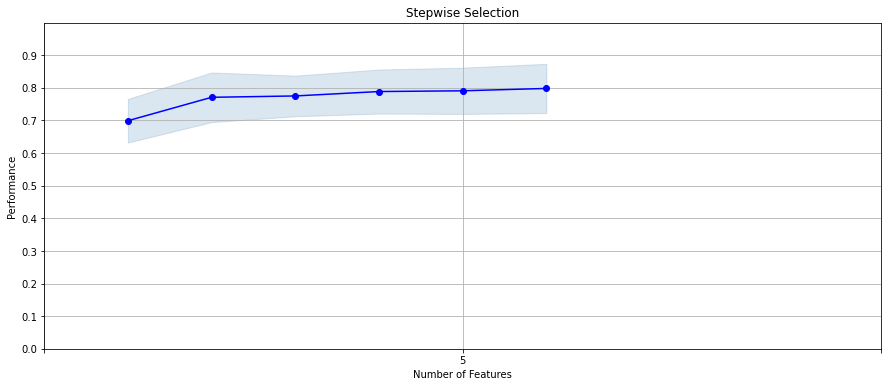

In [261]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,10)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [262]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(32,)","[0.707968901846453, 0.5919825072886298, 0.7702...",0.69925,"(beta,)",0.0860301,0.0669343,0.0334672
2,"(9, 32)","[0.6780855199222546, 0.697667638483965, 0.7830...",0.771087,"(grossProfits, beta)",0.0977712,0.0760693,0.0380346
3,"(9, 32, 355)","[0.7065111758989309, 0.7260932944606414, 0.781...",0.775237,"(grossProfits, beta, SIC_7372)",0.0801124,0.0623302,0.0311651
4,"(9, 32, 100, 355)","[0.7065111758989309, 0.7260932944606414, 0.784...",0.788739,"(grossProfits, beta, SIC_2834, SIC_7372)",0.0868319,0.0675582,0.0337791
5,"(9, 32, 100, 355, 457)","[0.7065111758989309, 0.7260932944606414, 0.784...",0.791027,"(grossProfits, beta, SIC_2834, SIC_7372, State...",0.0911507,0.0709183,0.0354592
6,"(9, 32, 100, 321, 355, 457)","[0.7065111758989309, 0.7260932944606414, 0.822...",0.798276,"(grossProfits, beta, SIC_2834, SIC_6211, SIC_7...",0.0971235,0.0755654,0.0377827


In [263]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [264]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(32,)","[0.707968901846453, 0.5919825072886298, 0.7702...",0.69925,"(beta,)",0.0860301,0.0669343,0.0334672,1.0,beta
2,"(9, 32)","[0.6780855199222546, 0.697667638483965, 0.7830...",0.771087,"(grossProfits, beta)",0.0977712,0.0760693,0.0380346,2.0,grossProfits
3,"(9, 32, 355)","[0.7065111758989309, 0.7260932944606414, 0.781...",0.775237,"(grossProfits, beta, SIC_7372)",0.0801124,0.0623302,0.0311651,3.0,SIC_7372
4,"(9, 32, 100, 355)","[0.7065111758989309, 0.7260932944606414, 0.784...",0.788739,"(grossProfits, beta, SIC_2834, SIC_7372)",0.0868319,0.0675582,0.0337791,4.0,SIC_2834
5,"(9, 32, 100, 355, 457)","[0.7065111758989309, 0.7260932944606414, 0.784...",0.791027,"(grossProfits, beta, SIC_2834, SIC_7372, State...",0.0911507,0.0709183,0.0354592,5.0,State_Location_TX
6,"(9, 32, 100, 321, 355, 457)","[0.7065111758989309, 0.7260932944606414, 0.822...",0.798276,"(grossProfits, beta, SIC_2834, SIC_6211, SIC_7...",0.0971235,0.0755654,0.0377827,6.0,SIC_6211


In [265]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
X = X[vars_keep_list]
X

,beta,grossProfits,SIC_7372,SIC_2834,State_Location_TX,SIC_6211
0,-0.052070,8.532663,4.662279,-0.279848,-0.303221,-0.102598
1,-0.036490,10.873101,-0.214487,-0.279848,-0.303221,-0.102598
2,-0.036490,10.873101,-0.214487,-0.279848,-0.303221,-0.102598
3,-0.030478,14.726530,-0.214487,-0.279848,-0.303221,-0.102598
4,0.067615,0.773444,-0.214487,-0.279848,-0.303221,-0.102598
...,...,...,...,...,...,...
3451,-0.061890,-0.258495,-0.214487,-0.279848,-0.303221,-0.102598
3452,-0.144657,-0.260223,-0.214487,-0.279848,-0.303221,-0.102598
3453,-0.141070,-0.256144,-0.214487,-0.279848,-0.303221,-0.102598
3454,-0.099213,-0.255105,-0.214487,-0.279848,-0.303221,-0.102598


In [333]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold

xgb = xgb.XGBClassifier()

parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'gamma':[0.01, 0.1, 0.2, 0.5, 1, 5],
              'eta': [0.1, 0.2, 0.5],
              'max_delta_step':[0],
              'sampling_method':['uniform'],
              'max_depth': [3,5,7,8],
              'min_child_weight': [0.6],
              'subsample': [0.8],
              'n_estimators': [5,10,20], 
              'scale_pos_weight': [Y.value_counts()[0] / Y.value_counts()[1]],
              'reg_alpha':[0,0.1],
              'silent': [1],
              'seed': [2022]}

clf = GridSearchCV(xgb, parameters, 
                   cv = StratifiedKFold(5).split(X, Y), #Unbalnaced data, thus StratifiedKFold
                   scoring='recall',
                   verbose=2, refit=True)
clf.fit(X, Y)


#lr = LogisticRegression()

#parameters = {'C':[0.01,0.05,0.1,0.2,0.5,1,2],'class_weight':['balanced']}

#clf = GridSearchCV(lr, parameters, 
                   #cv = StratifiedKFold(5).split(X, Y), #Unbalnaced data, thus StratifiedKFold
                   #scoring='roc_auc',
                   #verbose=2, refit=True)
#clf.fit(X, Y)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, obj


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objec


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, obj


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[18:58:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameter

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, obje

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:58:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, obje

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[18:59:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Paramet

[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[18:59:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameter

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, ob


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, obje

[18:59:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Paramet

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[18:59:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameter


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, o

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[18:59:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Paramet

[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, ob


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objectiv

[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[18:59:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=b

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objectiv

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objectiv

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=b

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objectiv

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objectiv

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=b


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objecti

[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objectiv

[19:00:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: {

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objectiv

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objectiv

[19:00:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[19:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[19:00:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.1, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4,

[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, 

[19:00:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Paramet

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4,

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4,

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, ob

[19:00:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Param

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4,

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, ob

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4,

[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4,

[19:00:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:00:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[19:01:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Paramet

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objec

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, ob

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objec

[19:01:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameter

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, ob

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objec


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV]  eta=0.2, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, object


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objectiv

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objec

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[19:01:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:

[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, object

[19:01:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: {

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:01:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, object

[19:02:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sil

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[19:02:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=

[CV]  eta=0.2, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=bi


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[19:02:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sil

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=b

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[19:02:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.2, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[19:02:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objecti

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, object

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, obj

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, object

[19:02:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:02:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameter

[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.01, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, obj

[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, object

[19:03:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objectiv

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.5s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, object


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objectiv


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objec

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, object

[19:03:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objectiv

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[19:03:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[19:03:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.2, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objec

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, object

[19:03:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[19:03:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters:

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:03:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objec

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, object

[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=0.5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, object

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[19:04:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bin

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[19:04:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { s

[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=1, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[19:04:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sil

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=3, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=10, nthread=4, objective=bi

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=5, min_child_weight=0.6, n_estimators=20, nthread=4, objective=bi

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binar


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=10, nthread=4, objective

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=7, min_child_weight=0.6, n_estimators=20, nthread=4, objective=

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.1s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=5, nthread=4, objective=b


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.2s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=10, nthread=4, objecti

[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8, total=   0.3s
[CV] eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.1, sampling_method=uniform, scale_pos_weight=122.42857142857143, seed=2022, silent=1, subsample=0.8 
[19:04:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  eta=0.5, gamma=5, max_delta_step=0, max_depth=8, min_child_weight=0.6, n_estimators=20, nthread=4, objectiv

[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:  6.5min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000220A425A3C0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=n...
             param_grid={'eta': [0.1, 0.2, 0.5],
                         'gamma': [0.01, 0.1, 0.2, 0.5, 1, 5],
                         'max_delta_step': [0], 'max_depth': [3, 5, 7, 8],
                         'min_child_weight': [0.6], 'n_estimators': [5, 10, 20],
                         'nthread': [4], 'objective

In [334]:
clf.best_params_

{'eta': 0.2,
 'gamma': 0.01,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 0.6,
 'n_estimators': 5,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': 122.42857142857143,
 'seed': 2022,
 'silent': 1,
 'subsample': 0.8}

In [335]:
pred_proba = clf.predict_proba(X)[:,1]
pred_proba

array([0.34156266, 0.2264941 , 0.2264941 , ..., 0.192591  , 0.27225554,
       0.3142023 ], dtype=float32)

In [336]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y, pred_proba, pos_label=1)
metrics.auc(fpr, tpr)

0.9839973328888149

In [338]:
df = pd.read_csv('final_results.csv')
df = df.groupby('CIK').head(1) #only use the lastest result from each company
data_cik = pd.DataFrame(data_json).T
df = df.merge(data_cik, how = 'inner', left_on = 'CIK', right_on = 'cik_str')
df.drop(['Ticker', 'cik_str', 'title'], axis = 1, inplace = True)
facts_table = pd.read_csv('facts_table.csv')
df = df.merge(facts_table, how = 'inner', on = 'ticker')
df['Pred_Proba'] = pred_proba
df['Y'] = Y
#df.drop(keywords, axis = 1, inplace = True)
df.drop(col_table, axis = 1, inplace = True)
df.drop(facts_col, axis = 1, inplace = True)
df.drop('Unnamed: 0', axis = 1, inplace = True)
df = df[df['Y'] != 1].sort_values(by = 'Pred_Proba', ascending = False).iloc[0:30,:]
df.drop('Y', axis = 1, inplace = True)
df

,CIK,Company Name,SIC,Industry,State Location,State Inc,Filling Date,URL,digital asset,cryptocurrency,cryptocurrencies,digital holdings,bitcoin,ethereum,ticker,Pred_Proba
2714,1384195,"RING ENERGY, INC.",1311,CRUDE PETROLEUM & NATURAL GAS,TX,NV,2022-03-16,https://www.sec.gov/Archives/edgar/data/138419...,0,0,0,0,0,0,REI,0.778125
1565,61398,TELLURIAN INC. /DE/,1311,CRUDE PETROLEUM & NATURAL GAS,TX,DE,2022-02-23,https://www.sec.gov/Archives/edgar/data/61398/...,0,0,0,0,0,0,TELL,0.778125
3433,1780097,"Baudax Bio, Inc.",8090,SERVICES,PA,PA,2022-03-16,https://www.sec.gov/Archives/edgar/data/178009...,0,0,0,0,0,0,BXRX,0.778125
3052,1864448,Wejo Group Ltd,7374,SERVICES,X0,D0,2022-03-31,https://www.sec.gov/Archives/edgar/data/186444...,0,0,0,0,0,0,WEJOW,0.778125
3445,1437925,"Golden Matrix Group, Inc.",7372,SERVICES,NV,NV,2021-04-30,https://www.sec.gov/Archives/edgar/data/143792...,0,0,0,0,0,0,GMGI,0.778125
3051,1864448,Wejo Group Ltd,7374,SERVICES,X0,D0,2022-03-31,https://www.sec.gov/Archives/edgar/data/186444...,0,0,0,0,0,0,WEJO,0.778125
2493,1816613,Markforged Holding Corp,3577,COMPUTER PERIPHERAL EQUIPMENT,MA,DE,2022-03-31,https://www.sec.gov/Archives/edgar/data/181661...,0,0,0,0,0,0,MKFG,0.719283
3189,1084577,CYREN Ltd.,7372,SERVICES,L3,L3,2022-03-24,https://www.sec.gov/Archives/edgar/data/108457...,0,0,0,0,0,0,CYRN,0.699353
3427,1023198,"StemGen, Inc.",7372,SERVICES,TX,DE,2021-10-15,https://www.sec.gov/Archives/edgar/data/102319...,0,0,0,0,0,0,SGNI,0.699353
3225,1070050,AppTech Payments Corp.,7372,SERVICES,CA,CA,2022-03-31,https://www.sec.gov/Archives/edgar/data/107005...,0,0,0,0,0,0,APCX,0.699353


In [38]:
df.to_csv('target_companies.csv', index = False)